In [37]:
import os
import psutil

def toRelPath(origPath):
    """Converts path to path relative to current script

    origPath:	path to convert
    """
    try:
        if not hasattr(toRelPath, "__location__"):
            toRelPath.__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__)))
        return os.path.join(toRelPath.__location__, origPath)
    except NameError:
        return origPath
    
def getMBUsage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1e6
    
#0: 1080Ti, 1: 940MX
#os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

####end of library

In [38]:
import json
import pymysql
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
def loadHistoricalStats(
    cacheLoc,
    useCache = False,
    metrics = [],
    startTime = None,
    endTime = None,
    timestepSize = 500,
    sqlHost = "inmensus-trading-db-1.ce50oojfsygk.us-east-2.rds.amazonaws.com",
    sqlUser = "GILGAMESH",
    sqlPassword = None,
    sqlDB = "inmensus_trading_db_1",
    queryLimit = 50000,
    maxPrice = 1000000
):
    """
    metrics: a combination of the following:
        "time"
        "max-bid"
        "min-ask"
        "mid"
        "bid-volume"
        "ask-volume"
        "last-trade"
        "oir"
    startTime: unix MS time
    endTime: unix MS time
    """
    
    EVENT_TBL = "gemini_events_btcusd"
    CKP_TBL = "gemini_checkpoints_btcusd"
    CKP_TIME_TBL = "gemini_checkpoint_times_btcusd"
    
    if useCache:
        #load the dataframe from the csv cache
        df = pd.read_csv(cacheLoc)
    else:
        print("Querying DB...")
        conn = pymysql.connect(
            host = sqlHost,
            user = sqlUser,
            passwd = sqlPassword,
            db = sqlDB
        )
        cur = conn.cursor()
        
        #get row count in each table
        dbTables = [EVENT_TBL, CKP_TBL, CKP_TIME_TBL]
        tableRows = {}
        for table in dbTables:
            cur.execute("SELECT COUNT(*) FROM " + table + ";")
            tableRows[table] = cur.fetchall()[0][0]
        
        if startTime == None:
            cur.execute("SELECT * FROM " + CKP_TIME_TBL + " LIMIT 1;")
            startTime = cur.fetchall()[0][0]
        if endTime == None:
            cur.execute("SELECT * FROM " + EVENT_TBL + " LIMIT 1 OFFSET " + str(tableRows[EVENT_TBL] - 1) + ";")
            endTime = cur.fetchall()[0][0]
            
        cur.execute("SELECT * FROM " + EVENT_TBL + 
                    " WHERE time >= " + str(startTime) + 
                    " AND time <= " + str(endTime) + 
                    " ORDER BY time ASC" + 
                    ";")
        events = cur.fetchall()
        cur.execute("SELECT MAX(time) FROM " + CKP_TIME_TBL + 
                    " WHERE time <= " + str(startTime) + 
                    ";")
        ckpTime = cur.fetchall()[0][0]
        cur.execute("SELECT * FROM " + CKP_TBL + 
                    " WHERE time = " + str(ckpTime) + 
                    ";")
        checkpoint = cur.fetchall()
        
        cur.close()
        conn.close()
        print("Finished querying DB.")
        
        #setup metrics
        firstTimestep = math.ceil(ckpTime / timestepSize) * timestepSize
        timesteps = math.floor((events[-1][0] - firstTimestep) / 500) + 1
        npMetrics = np.zeros((timesteps, len(metrics)))
        
        #initialize from checkpoint
        maxBid = 0
        minAsk = 100 * maxPrice
        curOB = np.zeros((math.ceil(maxPrice) * 100 + 1, 2))
        for event in checkpoint:
            curOB[int(round(event[2] * 100))][event[1]] = event[3]
            if event[3] > 0:
                if event[1] == 0:
                    maxBid = max(maxBid, int(round(event[2] * 100)))
                if event[1] == 1:
                    minAsk = min(minAsk, int(round(event[2] * 100)))
        
        #walk through events
        print(len(events), "events.")
        prevTimestep = firstTimestep
        lastTrade = None
        for a in range(0, len(events)):
            if a % 1000 == 0:
                print("Processing events... {:4.2f}%".format((a + 1) / len(events)), end = "\r")
            
            event = events[a]
            #only consider update events
            if event[4] == 0 or event[4] == 1 or event[4] == 5:
                continue
                
            if event[4] == 3:
                lastTrade = event[2]
                
            #walk through missed timesteps
            for prevTimestep in range(prevTimestep, event[0], timestepSize):
                ts = (prevTimestep - firstTimestep) // timestepSize
                #compute metrics
                cMetric = 0
                if "time" in metrics:
                    npMetrics[ts, cMetric] = prevTimestep
                    cMetric += 1
                if "max-bid" in metrics:
                    npMetrics[ts, cMetric] = maxBid / 100
                    cMetric += 1
                if "min-ask" in metrics:
                    npMetrics[ts, cMetric] = minAsk / 100
                    cMetric += 1
                if "mid" in metrics:
                    npMetrics[ts, cMetric] = (maxBid + minAsk) / 200
                    cMetric += 1
                if "bid-volume" in metrics:
                    npMetrics[ts, cMetric] = curOB[maxBid]
                    cMetric += 1
                if "ask-volume" in metrics:
                    npMetrics[ts, cMetric] = curOB[minAsk]
                    cMetric += 1
                if "last-trade" in metrics:
                    npMetrics[ts, cMetric] = lastTrade
                    cMetric += 1
                if "oir" in metrics:
                    npMetrics[ts, cMetric] = None
                    cMetric += 1
                
            #update ob
            pp = int(round(event[2] * 100))
            if event[1] == 1: #ask
                if event[3] > 0:
                    minAsk = min(minAsk, pp)
                else:
                    for minAsk in range(minAsk + 1, maxPrice + 1):
                        if curOB[minAsk][1] > 0:
                            break
            else: #bid
                if event[3] > 0:
                    maxBid = max(maxBid, pp)
                else:
                    for maxBid in range(maxBid, -1, -1):
                        if curOB[maxBid][0] > 0:
                            break
            curOB[pp][event[1]] = event[3]
        print("Done.")
        del checkpoint
        del events
        del curOB
        
        #convert to dataframe
        df = pd.DataFrame(npMetrics, columns = metrics)
        del npMetrics
        
        #write to csv cache
        df.to_csv(cacheLoc, index = False)
            
    return df

In [40]:
print(loadHistoricalStats(toRelPath("data\\dataframe-cache.csv"), 
                          metrics = ["time", "max-bid", "min-ask", "mid", "last-trade"],
                          sqlPassword = "3Dd7tAN66wqbjDaD"))

Querying DB...
Finished querying DB.
46169 events.
Done.ssing events... 1.00%
              time  max-bid  min-ask       mid  last-trade
0     1.531930e+12  7436.95  7437.04  7436.995         NaN
1     1.531930e+12  7436.95  7437.08  7437.015         NaN
2     1.531930e+12  7436.95  7437.08  7437.015         NaN
3     1.531930e+12  7436.95  7437.08  7437.015         NaN
4     1.531930e+12  7436.95  7437.08  7437.015         NaN
5     1.531930e+12  7436.95  7437.11  7437.030         NaN
6     1.531930e+12  7436.95  7437.04  7436.995         NaN
7     1.531930e+12  7436.95  7437.01  7436.980         NaN
8     1.531930e+12  7436.95  7437.07  7437.010         NaN
9     1.531930e+12  7436.95  7436.99  7436.970         NaN
10    1.531930e+12  7436.95  7437.02  7436.985         NaN
11    1.531930e+12  7436.95  7436.99  7436.970         NaN
12    1.531930e+12  7436.95  7436.98  7436.965         NaN
13    1.531930e+12  7436.95  7436.96  7436.955         NaN
14    1.531930e+12  7436.95  7436.96 

In [41]:
print(loadHistoricalStats(toRelPath("data\\dataframe-cache.csv"), 
                          useCache = True))

              time  max-bid  min-ask       mid  last-trade
0     1.531930e+12  7436.95  7437.04  7436.995         NaN
1     1.531930e+12  7436.95  7437.08  7437.015         NaN
2     1.531930e+12  7436.95  7437.08  7437.015         NaN
3     1.531930e+12  7436.95  7437.08  7437.015         NaN
4     1.531930e+12  7436.95  7437.08  7437.015         NaN
5     1.531930e+12  7436.95  7437.11  7437.030         NaN
6     1.531930e+12  7436.95  7437.04  7436.995         NaN
7     1.531930e+12  7436.95  7437.01  7436.980         NaN
8     1.531930e+12  7436.95  7437.07  7437.010         NaN
9     1.531930e+12  7436.95  7436.99  7436.970         NaN
10    1.531930e+12  7436.95  7437.02  7436.985         NaN
11    1.531930e+12  7436.95  7436.99  7436.970         NaN
12    1.531930e+12  7436.95  7436.98  7436.965         NaN
13    1.531930e+12  7436.95  7436.96  7436.955         NaN
14    1.531930e+12  7436.95  7436.96  7436.955         NaN
15    1.531930e+12  7436.95  7436.96  7436.955         N

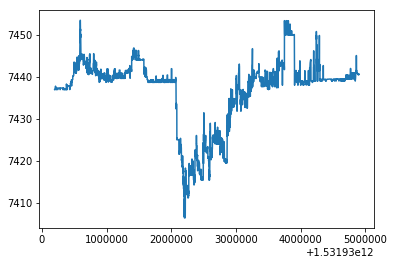

In [42]:
df = loadHistoricalStats(toRelPath("data\\dataframe-cache.csv"), 
                          useCache = True)
plt.plot(df.loc[:, "time"], df.loc[:, "mid"])